In [1]:
import os
import sys
import h5py
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns
import pickle
import copy
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing as mp
import scipy.stats as ss
import seaborn as sns
import keras
import scipy
from scipy.stats import norm
from datetime import datetime
from keras.models import load_model
from keras.models import Sequential
from keras.layers import *
from keras.models import Model
from keras import backend as K    
from sklearn.metrics import roc_auc_score as auroc
from sklearn.metrics import precision_recall_curve
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Load multi-scale footprint and TF binding data

In [2]:
dataset = "HepG2"
hf = h5py.File("../../data/" + dataset + "/TFBSData.h5", 'r')

# Multi-scale footprint scores for each TF motif site
# Here we use footprints calculated using 6 different window sizes:
# 10bp, 20bp, 30bp, 50bp, 80bp, 100bp (radius, not diameter)
# For each window radius, we take a 201 bp (+/- 100bp with the motif center 1bp) local neighborhood 
# as model input. Therefore for each locus we have a 201 * 6 = 1206 dimensional vector as input
# If we have in total N motif matched sites, then hf['motifFootprints'] should be a N-by-1026 matrix
footprints = hf['motifFootprints']
footprints = np.transpose(np.array(footprints))

# Metadata of each motif site
metadata = hf['metadata']
metadata = np.array(metadata)

# Ground truth TF binding label. An array of 0s (unbound) and 1s (bound).
TF_bound = np.array([i[0] for i in metadata])

# Motif match scores. Describe how well a motif is matched
motif_score = np.array([i[1] for i in metadata])

# The corresponding TF names for each motif site
TF_labels = np.array([i[2].decode('ascii') for i in metadata])
kept_TFs = np.unique(TF_labels)

# Scale the features so that we can intepret input gradient later
footprint_mean = np.mean(footprints, axis = 0)
footprint_sd = np.std(footprints, axis = 0)
footprints = (footprints - footprint_mean) / footprint_sd

# Combine all non-footprint features as additional features
motif_score = np.reshape(motif_score, (-1, 1))
TFBS_data = np.concatenate([footprints, motif_score], axis = 1)

In [3]:
# Load pre-trained TF binding prediction model
model = load_model("../../data/TFBSPrediction/TFBS_model.h5")

2022-08-12 11:49:26.062134: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/helmod/apps/centos7/Core/cuda/11.1.0-fasrc01/cuda/extras/CUPTI/lib64:/n/helmod/apps/centos7/Core/cuda/11.1.0-fasrc01/cuda/lib64:/n/helmod/apps/centos7/Core/cuda/11.1.0-fasrc01/cuda/lib:/n/helmod/apps/centos7/Core/cudnn/8.1.0.77_cuda11.2-fasrc01/lib64
2022-08-12 11:49:26.063038: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-12 11:49:26.063475: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (holy7c24301.rc.fas.harvard.edu): /proc/driver/nvidia/version does not exist
2022-08-12 11:49:26.064535: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneD

## 1. Calculate contribution by 20 bp radius footprint signal

In [4]:
# We know that the footprint at 20 bp radius (40 bp diameter in our paper) scale corresponds to
# the presence of TF. We want to evaluate the contribution of this signal to model prediction.
# To this end, we try masking the 20 bp footprint signal at different positions and see how it 
# affects model prediction

### 1.1 For a specific TF and specific spatial scale, we mask different locations around the motif and evaluate effect

In [5]:
# Retrieve model input for a specific TF
TF = "NRF1"
TF_data = TFBS_data[np.logical_and(TF_labels == TF, TF_bound == 1), :]
radius = 100
window_size = 2 * radius + 1

# Divide local neighborhood into bins of 10 bp for masking
bin_size = 10

# Which scale to mask. If kernel_ind = 1 we mask 20 bp radius footprints.
# If kernel_ind = 2 we mask 30 bp radius footprints.. so on so forth
kernel_ind = 1 
kernel_start = kernel_ind * window_size
n_bins = int(radius * 2 / bin_size)

# Model prediction without masking
original_prediction = np.transpose(model.predict(TF_data))[0]

# Mask different location bins and evaluate effect
contribution_matrix = []
for bin_ind in tqdm.tqdm(range(n_bins)):
    bin_start = kernel_start + bin_ind * bin_size
    bin_end = bin_start + bin_size
    masked_TF_data = copy.deepcopy(TF_data)
    for feature_ind in np.arange(bin_start, bin_end):
        # Mask feature by setting them to the minimum signal detected
        masked_TF_data[:, feature_ind] = np.min(TF_data[:, feature_ind])
    perturbed_prediction = np.transpose(model.predict(masked_TF_data))[0]
    contribution_matrix.append(original_prediction - perturbed_prediction)
contribution_matrix = np.abs(np.transpose(contribution_matrix))

2022-08-12 13:52:53.354290: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
100%|██████████| 20/20 [00:02<00:00,  6.77it/s]


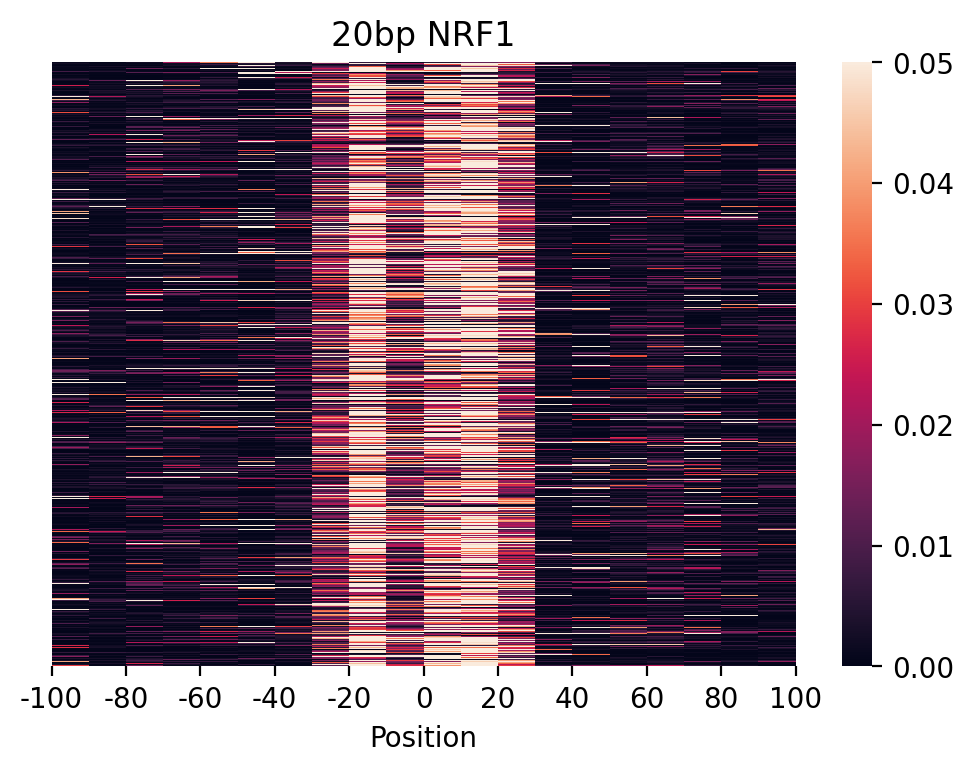

In [6]:
n_sample = 1000
sample_ind = np.random.choice(np.arange(np.shape(TF_data)[0]), n_sample)
plt.figure(dpi = 200)
ax = sns.heatmap(np.array(contribution_matrix[sample_ind, :]), 
            vmax = 0.05, yticklabels = False)
ax.set_xticks(np.arange(0, 21, 2))
ax.set_xticklabels(np.arange(-100,101, 20))
ax.set_xlabel("Position")
ax.set_title("20bp " + TF)
plt.show()

### 1.2 For a specific spatial scale, we go through all TFs and evaluate the effect of masking the signal immediately surrounding the center motif

In [7]:
radius = 100
window_size = 2 * radius + 1
bin_size = 10
kernel_ind = 1
bin_start = kernel_ind * window_size + radius - bin_size
bin_end = kernel_ind * window_size + radius + bin_size

TF_fp_contribution = []
for TF in tqdm.tqdm(kept_TFs):
    TF_data = TFBS_data[np.logical_and(TF_labels == TF, TF_bound == 1), :]
    original_prediction = np.transpose(model.predict(TF_data))[0]
    masked_TF_data = copy.deepcopy(TF_data)
    for feature_ind in np.arange(bin_start, bin_end):
        masked_TF_data[:, feature_ind] = np.min(TF_data[:, feature_ind])
    perturbed_prediction = np.transpose(model.predict(masked_TF_data))[0]
    TF_fp_contribution.append(np.mean(original_prediction - perturbed_prediction))

100%|██████████| 46/46 [00:17<00:00,  2.62it/s]


In [8]:
TF_fp_contribution, kept_TFs = list(zip(*sorted(zip(TF_fp_contribution, kept_TFs), reverse = True)))

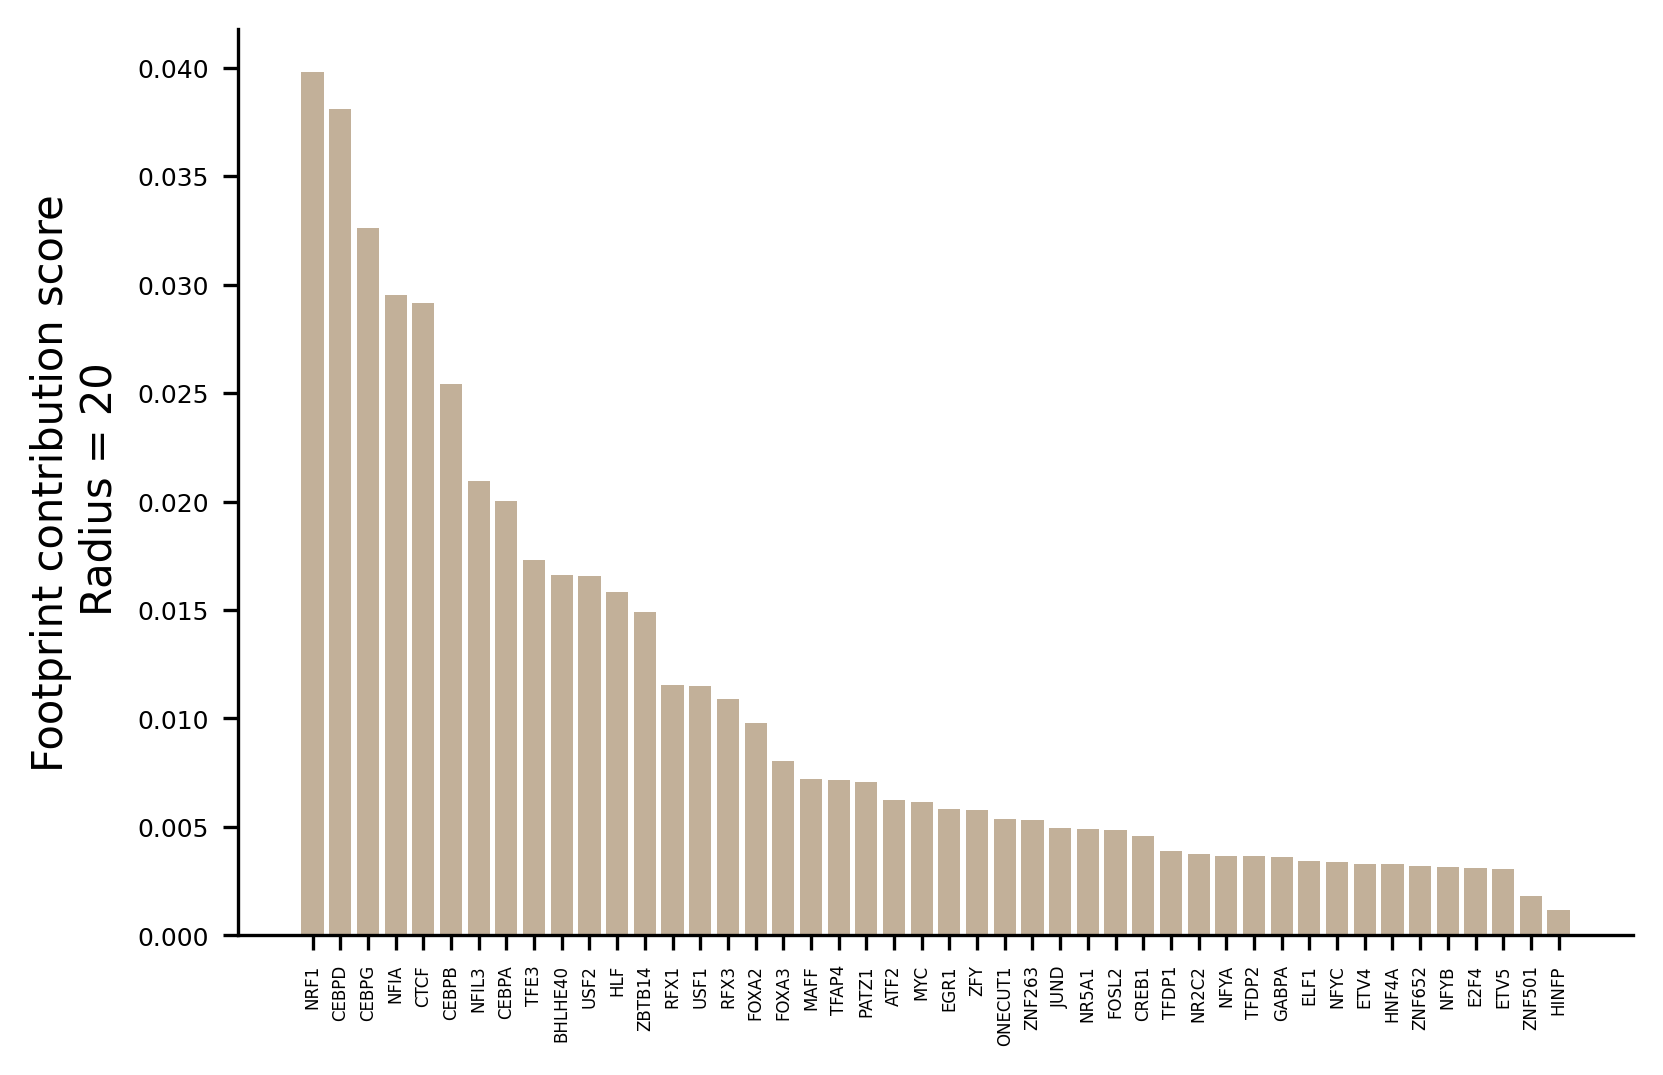

In [9]:
fig, ax = plt.subplots(dpi = 300)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.bar(kept_TFs, TF_fp_contribution, color = "#C2B099")
plt.yticks(fontsize = 6)
plt.xticks(rotation = 90, fontsize = 4)
plt.ylabel("Footprint contribution score\nRadius = 20 ")
if not os.path.isdir("../../data/TFBSPrediction/plots/"):
    os.mkdir("../../data/TFBSPrediction/plots/")
plt.savefig('../../data/TFBSPrediction/plots/20bpContribution.pdf')  
plt.show()

In [10]:
d = {'TF': kept_TFs, 'contribution': TF_fp_contribution}
df = pd.DataFrame(data=d)
df.to_csv("../../data/TFBSPrediction/" + dataset + "_TF_fp_contribution.tsv",
         sep = "\t")

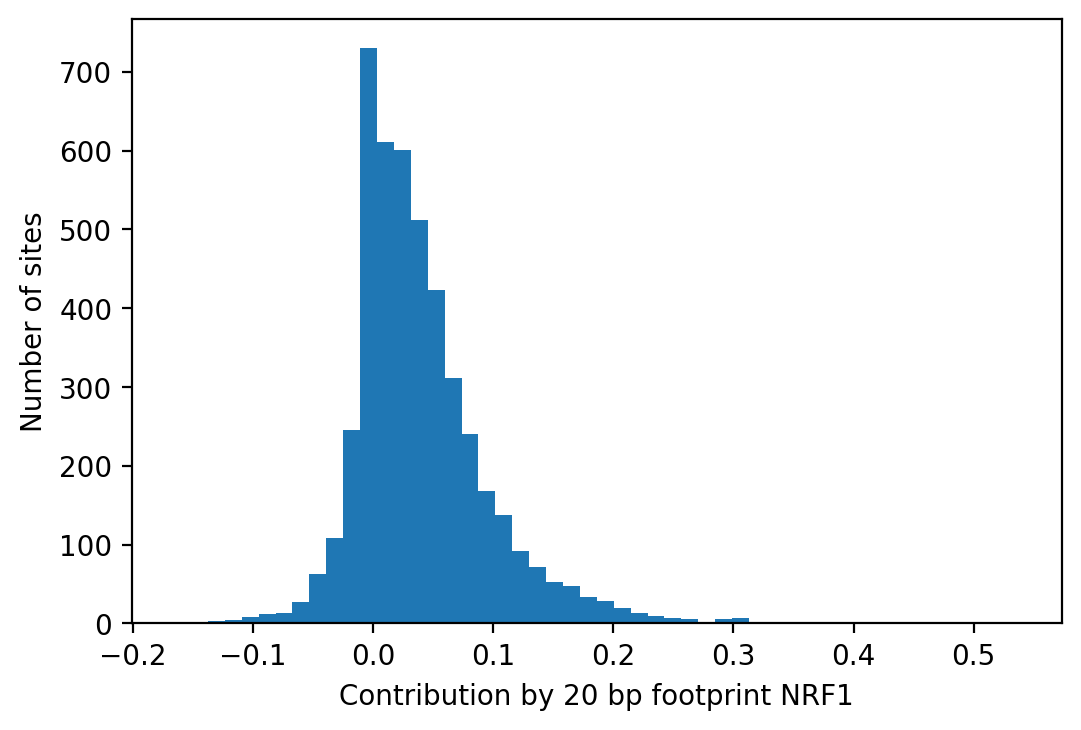

In [11]:
TF = "NRF1"
radius = 100
window_size = 2 * radius + 1
bin_size = 10
kernel_ind = 1
bin_start = kernel_ind * window_size + radius - bin_size
bin_end = kernel_ind * window_size + radius + bin_size
TF_data = TFBS_data[np.logical_and(TF_labels == TF, TF_bound == 1), :]
original_prediction = np.transpose(model.predict(TF_data))[0]
masked_TF_data = copy.deepcopy(TF_data)
for feature_ind in np.arange(bin_start, bin_end):
    masked_TF_data[:, feature_ind] = np.min(TF_data[:, feature_ind])
perturbed_prediction = np.transpose(model.predict(masked_TF_data))[0]
plt.figure(dpi = 200)
plt.hist(original_prediction - perturbed_prediction, bins = 50)
plt.xlabel("Contribution by 20 bp footprint " + TF)
plt.ylabel("Number of sites")
plt.show()

## 2. Spatial constraints between nucleosome positioning and TF binding

In [12]:
# Here we simulate signals of nucleosomes and TFs and evaluate how nucleosome
# positioning affects model prediction scores

In [13]:
# Generate a signal track with simulated footprints
def simulate_signal(positions, 
                    footprint_radius, 
                    max_signal = 3,
                    window_radius = 100):
    
    # Simulate the signal of a single footprint
    window_width = 2 * window_radius + 1
    footprint = norm.pdf(np.linspace(start=-3, stop=3, num=2 * footprint_radius)) * 10
    footprint = footprint * max_signal / np.max(footprint)
    
    # Add simulated footprints to designated positions
    signal_track = np.zeros(window_width)
    if type(positions) == int:
        positions = [positions]
    for pos in positions:
        footprint_start = max(0, footprint_radius - window_radius - pos)
        footprint_end = min(len(footprint), footprint_radius + (window_radius - pos))
        track_start = max(0, (pos + window_radius - footprint_radius))
        track_end = min(window_width, (pos + window_radius + footprint_radius))
        signal_track[track_start : track_end] = np.maximum(signal_track[track_start : track_end], \
                                                           footprint[footprint_start : (footprint_end + 1)])
    return signal_track

### 2.1 Determine representative footprint shape left by a TF

In [14]:
# This function correlates each row of the matrix X with the vector y
def vcorrcoef(X,y):
    Xm = np.reshape(np.mean(X,axis=1),(X.shape[0],1))
    ym = np.mean(y)
    r_num = np.sum((X-Xm)*(y-ym),axis=1)
    r_den = np.sqrt(np.sum((X-Xm)**2,axis=1)*np.sum((y-ym)**2))
    r = r_num/r_den
    return r

/tmp/ipykernel_50041/3857148742.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(np.arange(-150,101,50))
/tmp/ipykernel_50041/3857148742.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(np.arange(-150,101,50))
/tmp/ipykernel_50041/3857148742.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(np.arange(-150,101,50))


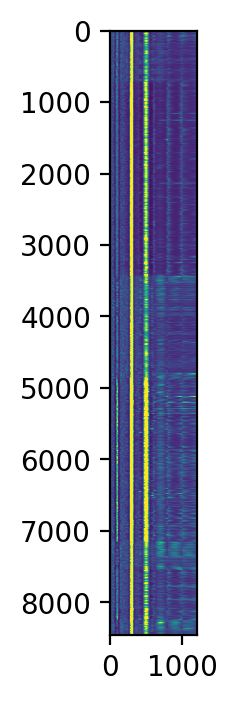

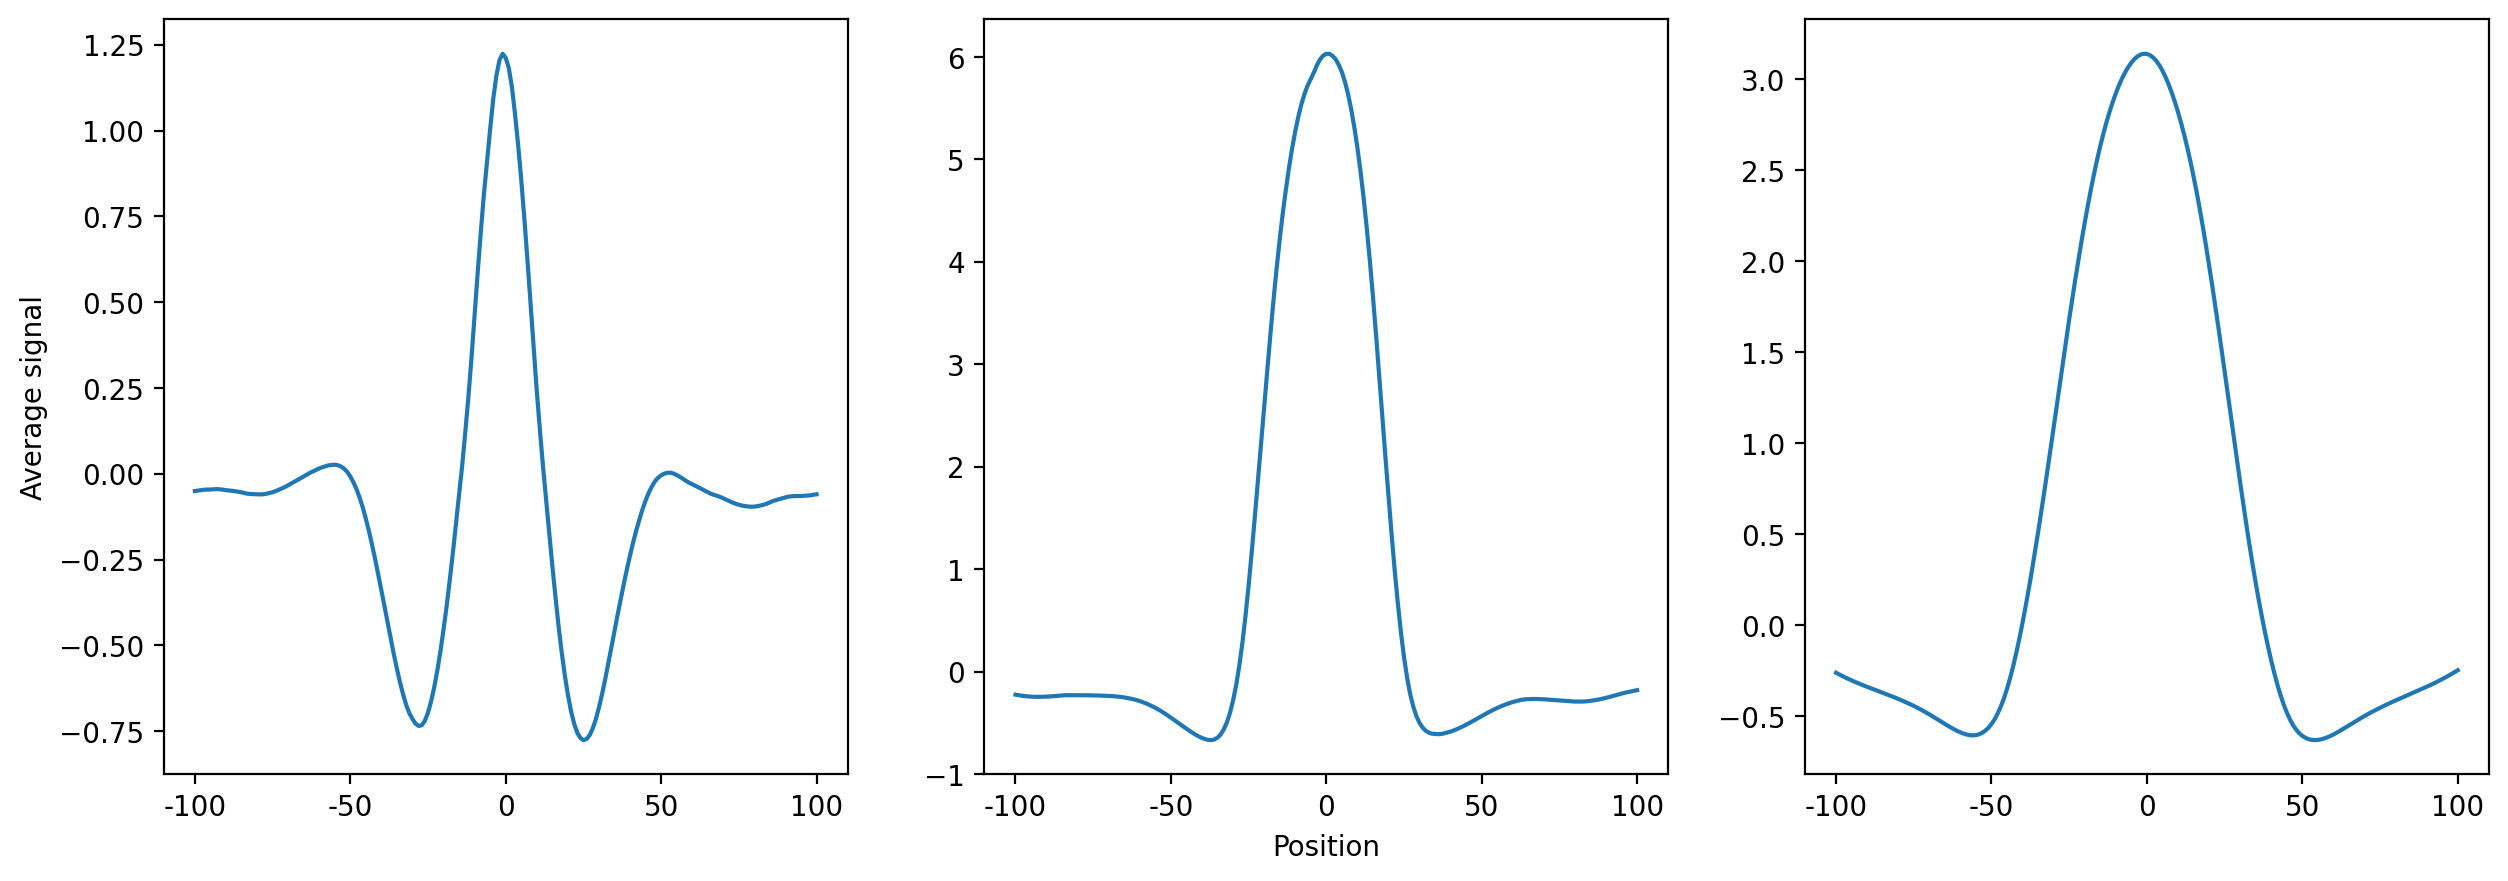

In [15]:
# First generate a initial simulation of TF signal
position = 0
TF_track = simulate_signal(positions = position, 
                                   footprint_radius = 30)

# Find real observations roughly matching this signal
corr = vcorrcoef(footprints[:, 201:402], TF_track)
matched_inds = np.logical_and(corr > 0.8, footprints[:, 301 + position] > 3)
plt.figure(dpi = 200)
plt.imshow(footprints[matched_inds, :], vmax = 3)

fig, ax = plt.subplots(1, 3, figsize = (15,5), dpi = 200)
ax[0].plot(np.mean(footprints[matched_inds, 0:201], axis = 0))
ax[0].set_ylabel("Average signal")
ax[0].set_xticklabels(np.arange(-150,101,50))
ax[1].plot(np.mean(footprints[matched_inds, 201:402], axis = 0))
ax[1].set_xticklabels(np.arange(-150,101,50))
ax[1].set_xlabel("Position")
ax[2].plot(np.mean(footprints[matched_inds, 402:603], axis = 0))
ax[2].set_xticklabels(np.arange(-150,101,50))
plt.show()

# Then get the actual size of a TF footprint by averaging over real observations
TF_max_signal = []
TF_radius = []
for i in range(3):
    profile = np.mean(footprints[matched_inds, (201 * i):(201 * (i + 1))], axis = 0)
    radius = np.max([r for r in range(1, 50) if np.min(profile[(100 - r):(100 + r)]) > 0])
    TF_max_signal.append(np.max(profile))
    TF_radius.append(radius)

### 2.2 Determine representative footprint shape left by a nucleosome

/tmp/ipykernel_50041/516736980.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(np.arange(-150,101,50))
/tmp/ipykernel_50041/516736980.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(np.arange(-150,101,50))
/tmp/ipykernel_50041/516736980.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(np.arange(-150,101,50))


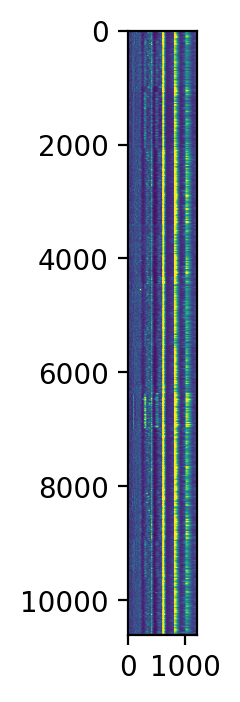

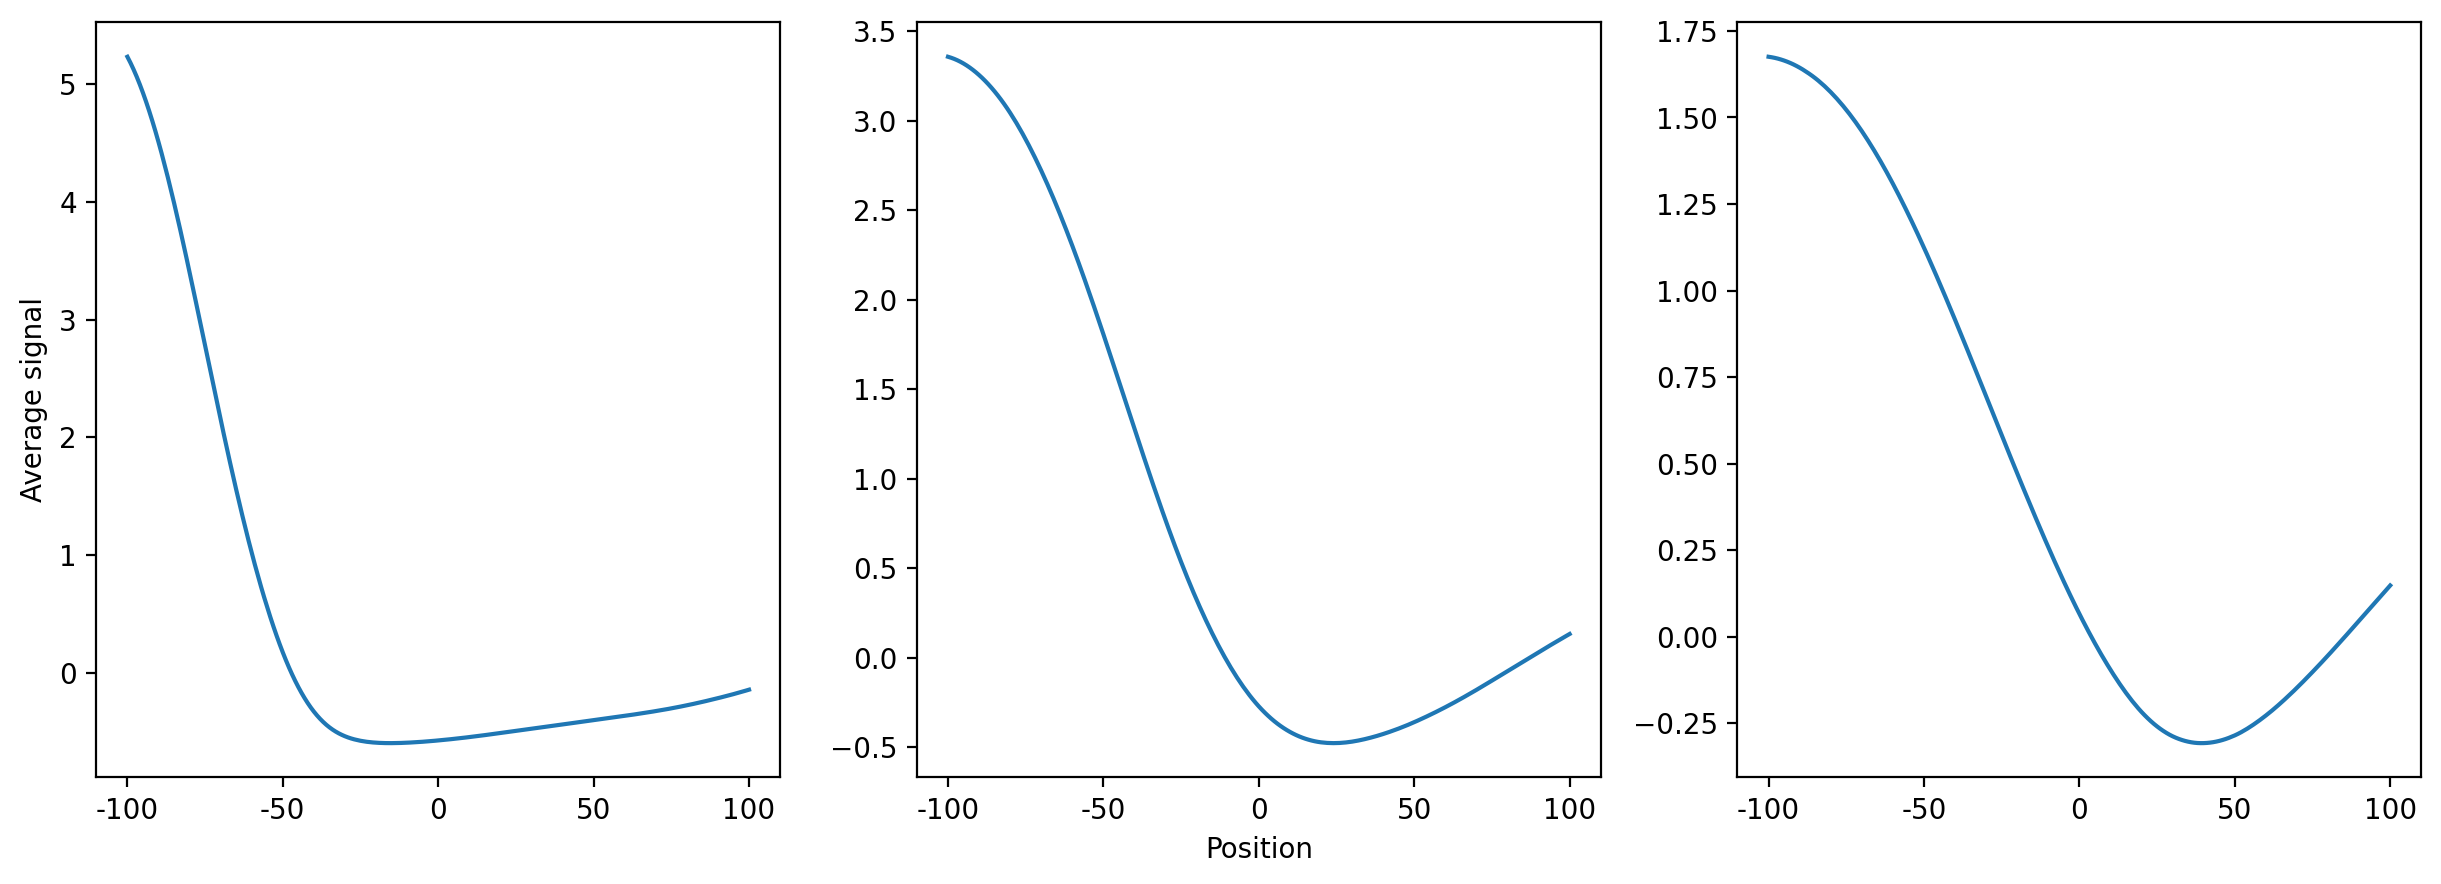

In [16]:
# First generate a initial simulation of nucleosome signal
position = -100
nucleosome_track = simulate_signal(positions = position, 
                                   footprint_radius = 50)

# Find real observations roughly matching this signal
corr = vcorrcoef(footprints[:, 603:804], nucleosome_track)
matched_inds = np.logical_and(corr > 0.8, footprints[:, 703 + position] > 3)
plt.figure(dpi = 200)
plt.imshow(footprints[matched_inds, :], vmax = 3)

fig, ax = plt.subplots(1, 3, figsize = (15,5), dpi = 200)
ax[0].plot(np.mean(footprints[matched_inds, 603:804], axis = 0))
ax[0].set_ylabel("Average signal")
ax[0].set_xticklabels(np.arange(-150,101,50))
ax[1].plot(np.mean(footprints[matched_inds, 804:1005], axis = 0))
ax[1].set_xticklabels(np.arange(-150,101,50))
ax[1].set_xlabel("Position")
ax[2].plot(np.mean(footprints[matched_inds, 1005:1206], axis = 0))
ax[2].set_xticklabels(np.arange(-150,101,50))
plt.show()

# Then get the actual size of a TF footprint by averaging over real observations
nucleosome_max_signal = []
nucleosome_radius = []
for i in range(3):
    profile = np.mean(footprints[matched_inds, (201 * (i + 3)):(201 * (i + 4))], axis = 0)
    radius = np.min(np.where(profile < 0))
    nucleosome_max_signal.append(np.max(profile))
    nucleosome_radius.append(radius)

In [17]:
print("For footprint signal with radius of 10bp, 20bp, and 30bp")
print("TF_max_signal", TF_max_signal)
print("TF_radius", TF_radius)
print()
print("For footprint signal with radius of 50bp, 80bp, and 100bp")
print("nucleosome_max_signal", nucleosome_max_signal)
print("nucleosome_radius", nucleosome_radius)

For footprint signal with radius of 10bp, 20bp, and 30bp
TF_max_signal [1.2236902797840652, 6.031083746033953, 3.1409967707249473]
TF_radius [13, 26, 38]

For footprint signal with radius of 50bp, 80bp, and 100bp
nucleosome_max_signal [5.233423272448635, 3.3578039688408126, 1.675428145707177]
nucleosome_radius [53, 90, 104]


### 2.3 Simulate a fixed TF at the center, and two nucleosomes at different position combinations

In [35]:
# Simulate the signal of a single TF at the center
TF_signal_scaling_factor = 1
TF_tracks = [simulate_signal(positions = 0, 
                             footprint_radius = TF_radius[i], 
                             max_signal = TF_max_signal[i] * TF_signal_scaling_factor) 
             for i in range(3)]

In [36]:
# Simulate the signal of two nucleosomes within the region
max_dist = 150
nucleosome_signal_scaling_factor = 2
nucleosome_size_scaling_factor = 1
input_tracks = []
positions = []
for pos_1 in tqdm.tqdm(np.arange(-max_dist, max_dist + 1)):
    for pos_2 in np.arange(-max_dist,max_dist + 1):
        nucleosome_tracks = [simulate_signal(positions = [pos_1, pos_2], 
                   footprint_radius = int(nucleosome_radius[i] * nucleosome_size_scaling_factor), 
                   max_signal = nucleosome_max_signal[i] * nucleosome_signal_scaling_factor) for i in range(3)]
        input_track = np.concatenate(TF_tracks + nucleosome_tracks + [[1]])
        input_tracks.append(input_track)
        positions.append([pos_1, pos_2])

100%|██████████| 301/301 [00:46<00:00,  6.45it/s]


In [37]:
# Predict TF binding score
scores = np.transpose(model.predict(np.array(input_tracks)))[0]
positions = np.array(positions)
score_matrix = np.zeros((max_dist * 2 + 1, max_dist * 2 + 1))
score_matrix[positions[:, 0] + max_dist, positions[:, 1] + max_dist] = scores

# Leverage symmetry of the system
score_matrix = (score_matrix + np.flip(np.flip(score_matrix, axis = 0), axis = 1)) / 2

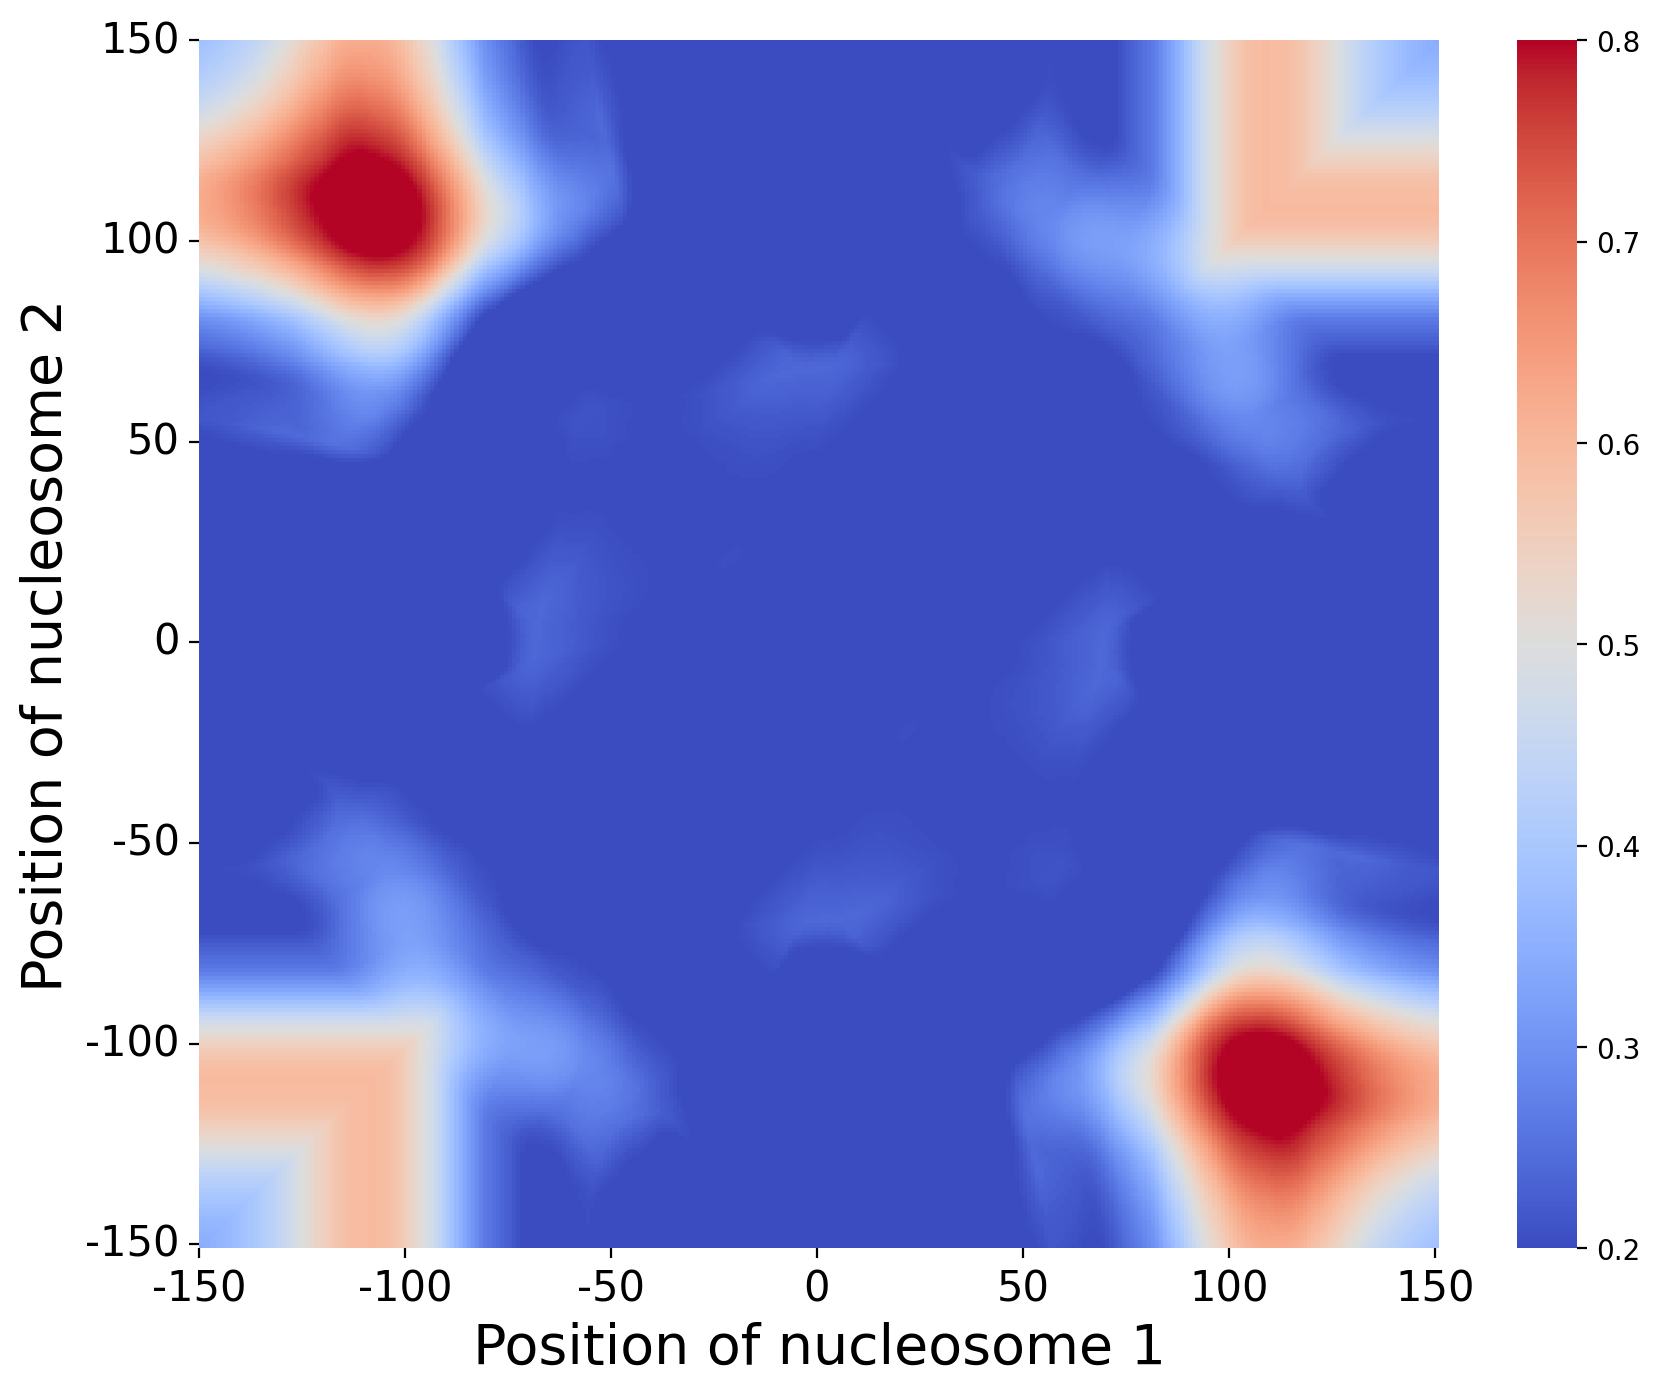

In [38]:
plt.figure(dpi = 200, figsize = (10, 8))
plt.xticks(np.arange(0, 2 * max_dist + 1, 50))
plt.yticks(np.arange(0, 2 * max_dist + 1, 50))
ax = sns.heatmap(np.flip(score_matrix, axis = 0), 
            vmin = 0.2, vmax = 0.8, cmap = sns.color_palette("coolwarm", as_cmap=True))
ax.set_yticks(np.arange(0, 2 * max_dist + 1, 50))
ax.set_yticklabels(np.flip(np.arange(-max_dist, max_dist + 1, 50)), fontsize = 15)
ax.set_xticks(np.arange(0, 2 * max_dist + 1, 50))
ax.set_xticklabels(np.arange(-max_dist, max_dist + 1, 50), 
                   fontsize = 15, rotation = 0)
plt.xlabel("Position of nucleosome 1", fontsize = 20)
plt.ylabel("Position of nucleosome 2", fontsize = 20)
plt.savefig("../../data/TFBSPrediction/plots/nucleosome_pos_TF_sig_" + \
            str(TF_signal_scaling_factor) + \
           "_nuc_sig_" + str(nucleosome_signal_scaling_factor) + \
           "_nuc_size_" + str(nucleosome_size_scaling_factor) + ".png",
           transparent=True)

### 2.4 Fix the two nucleosomes at +/- 100 bp positions, respectively. Change the width of the nucleosome using a scaling factor.

In [25]:
input_tracks = []
scaling_factors = np.arange(0.5, 1.5, 0.02)
for scaling_factor in scaling_factors:
    nucleosome_tracks = [simulate_signal(positions = [-100, 100], 
                       footprint_radius = int(nucleosome_radius[i] * scaling_factor), 
                       max_signal = nucleosome_max_signal[i]) for i in range(3)]
    input_track = np.concatenate(TF_tracks + nucleosome_tracks + [[1]])
    input_tracks.append(input_track)

In [26]:
scores = np.transpose(model.predict(np.array(input_tracks)))[0]

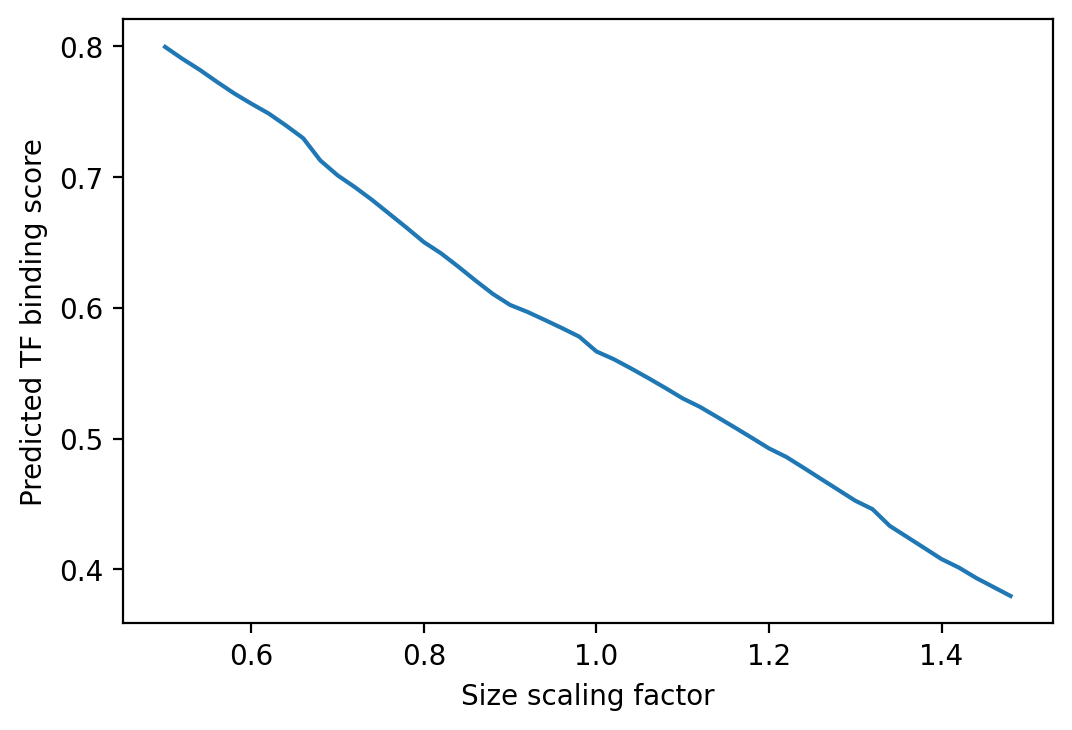

In [27]:
plt.figure(dpi = 200)
plt.plot(scaling_factors, scores)
plt.xlabel("Size scaling factor")
plt.ylabel("Predicted TF binding score")
plt.savefig("../../data/TFBSPrediction/plots/nucleosome_size.pdf")